In [45]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

from google.colab import files
files.upload()

{}

In [46]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle competitions download -c digit-recognizer

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Examining the data

In [0]:
Y_train = train['label']

X_train = train.drop(labels = 'label', axis = 1)

In [50]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Counts 784 columns, only 1 unique value which is ```False``` which occurs 784 times.


In [51]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [52]:
Y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

# Preprocessing the data

In [0]:
# Normalising
X_train = X_train / 255.0
test = test / 255.0

In [0]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [55]:
print(X_train.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [0]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [0]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [58]:
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [0]:
random_seed = 42

In [0]:
# Seperating into training and validation set

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed, stratify = Y_train)

In [0]:
model = Sequential()

# 1st layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.25))

# 2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [0]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
    
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [67]:
X_train.shape[0] // batch_size

439

In [68]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val),
                              verbose = 2, steps_per_epoch = X_train.shape[0] // batch_size
                              , callbacks = [learning_rate_reduction])

Epoch 1/10
 - 9s - loss: 0.5156 - acc: 0.8319 - val_loss: 0.0609 - val_acc: 0.9836
Epoch 2/10
 - 9s - loss: 0.1534 - acc: 0.9548 - val_loss: 0.0554 - val_acc: 0.9855
Epoch 3/10
 - 9s - loss: 0.1120 - acc: 0.9666 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 4/10
 - 9s - loss: 0.0902 - acc: 0.9728 - val_loss: 0.0314 - val_acc: 0.9919
Epoch 5/10
 - 9s - loss: 0.0819 - acc: 0.9759 - val_loss: 0.0333 - val_acc: 0.9931
Epoch 6/10
 - 8s - loss: 0.0735 - acc: 0.9783 - val_loss: 0.0288 - val_acc: 0.9938
Epoch 7/10
 - 8s - loss: 0.0715 - acc: 0.9793 - val_loss: 0.0318 - val_acc: 0.9924
Epoch 8/10
 - 9s - loss: 0.0657 - acc: 0.9809 - val_loss: 0.0325 - val_acc: 0.9933
Epoch 9/10
 - 9s - loss: 0.0656 - acc: 0.9816 - val_loss: 0.0252 - val_acc: 0.9950
Epoch 10/10
 - 8s - loss: 0.0595 - acc: 0.9828 - val_loss: 0.0294 - val_acc: 0.9929


batch_size - Size of batches of augmented data

// - Gives quotient

```steps_per_epoch = X_train.shape[0] // batch_size``` - Approx. 1 step per batch

In [0]:
Y_pred = model.predict(X_val)

In [70]:
Y_pred.shape

(4200, 10)

In [0]:
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_val_classes = np.argmax(Y_val, axis = 1)

In [0]:
from sklearn.metrics import confusion_matrix as cfm
cfm_array = cfm(Y_val_classes, Y_pred_classes)

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalise = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    cm - Confusion matrix array
    """
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) # Equally spaced values
    plt.xticks(tick_marks, classes, rotation = 45) # A list of positions at which ticks are to be placed.
    plt.yticks(tick_marks, classes)
    
    if normalise:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

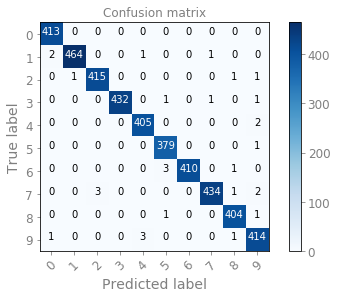

In [74]:
plot_confusion_matrix(cfm_array, classes = range(10))

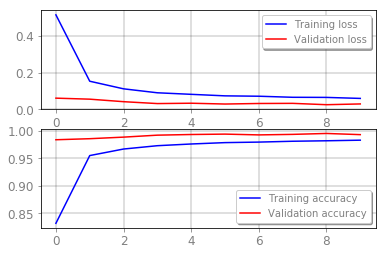

In [79]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
# from sklearn.model_selection import GridSearchCV

# grid_epochs = [10, 20, 30]
# grid_batch_sizes = [10, 20, 40, 80, 100]
# param_grid = dict(epochs = grid_epochs, batch_sizes = grid_batch_sizes)

# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'accuracy')
# grid_result = grid.fit(X_train, Y_train)

# grid_result.best_params_

In [0]:
# cv_results = grid_result.cv_results_

# for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
#   print(mean_score, params)

# Final results

In [78]:
results = model.predict(test)
results = np.argmax(results, axis = 1)
results = pd.Series(results, name = 'Label')

index = range(1, (test.shape[0] + 1))
submission = pd.concat([pd.Series(index, name = 'ImageId'), results], axis = 1)

submission.to_csv('digit_recognizer.csv', index = False) # index : Write row names

!kaggle competitions submit -c digit-recognizer -f digit_recognizer.csv -m "Message"

100% 208k/208k [00:01<00:00, 117kB/s]
Successfully submitted to Digit Recognizer